# Convolution Neural Networks

<p>One of the problems using deep neural networks is the large number of parameters that need to be trained. This requires a large amount of training data and there is always the problem of overfitting. This is especially the case when we use images as input. Even a low resolution image, say $28\times 28$ will already have 784 dimensions. Another problem is that whenever the resolution of the image changes, the input dimension changes, and the neural network is no longer applicable. Convolutional neural networks, CNN's in short,  come to the rescue!</p>

---
## Biological origin


<p> CNN's have an interesting biological origin in the Nobelprize-winning research of [Hubert and Wiesel](https://knowingneurons.com/2014/10/29/hubel-and-wiesel-the-neural-basis-of-visual-perception/). Quoting from the aforementioned webpage, *The classic experiments by Hubel and Wiesel are fundamental to our understanding of how neurons along the visual pathway extract increasingly complex information from the pattern of light cast on the retina to construct an image*. This is the process that we try to replicate with CNN's. A local filter is created that responds in the same way to similar stimuli in different parts of the image. by stacking multiple filters and neural layers, the CNN becomes capable of extracting increasingly complex information from the image. </p>

<p> Also note the reduction in the number of trainable coefficients. If we have a $3\times 3$ filter, we have only 9 unknown coefficients that we need to estimate during training. If we reduce the image, say an $28\times 28$ image in the usual way,  to a $784$-dimensional vector, 784 unknown coefficients need to be trained. Of course the savings is not quite as large since we'll use several small filters, but in general can be substantial.</p>


---
## Convolution

<br><br>


<figure> 
<figcaption>**Convolution**</figcaption>
<img src="./images/cnn_1.png"
     width=400px
     alt="Convolution"
     style="float: left"/> 
</figure>
<p>The Figure illustrates the idea of convolution as used in images. The attentive reader will note that it differ slightly from the usual definition. On the top, left a $5\times 5$ gray-scale image is shown. This is convolved with a $3\times3$ filter, shown to its right. The way it works is that the filter is placed on top of the image to cover a $3\times3$ patch of the image. The filter coefficients are then multiplied with the corresponding pixel values underneath the filter. These values are summed to produce a single output value, a pixel value of the new image. The filter is then moved one position over (in this example), and the process is repeated. </p>
<p> It is immediately apparent that we have a problem at the edges. If we fit the filter inside the original image, the resulting image is smaller. In this case it is reduced from a $5\times5$ image to a $3\times3$ image. This may not matter much, but if the same-sized output image as the original image is required, it is necessary to do something at the boundary. One frequently used technique is to pad the original images with zero's, as shown in the bottom, left image. The filter is then applied as before but in this case the output image dimension is the same as before.</p>

<p> There are several issues the reader should note:</p>
    
* We showed a $3\times3$ filter but obviously this is another hyperparameter that the user has to control. Larger filter sizes cover more of the image, and therefore take more context into account. Nowadays it seems as if the trend is to use smaller filter sizes.
* The amount of padding clearly depends on the filter size. Larger filter sizes require more padding.
* We moved the filter one step at a time. This is known as the *stride* and is also a hyperparameter. For larger filters a larger stride can be considered.
* Instead of outputting a single image, this is not what is done in practice since it does not provide sufficient 'richness' to the system to capture all the relevant information. Instead a whole stack of filters are used, perhaps as deep as 32 different filters. Each filter is applied to the image as before, and each filter outputs an image as before. Again this is a hyperparameter that the user should apply.
* In this example we started with a single image but if we were given a color image, we would have thought of that as three different images, each corresponding to one of the 3 primary colors in images: Red, Green, and Blue. The filter is applied to the whole stack of images, all the values are multiplied and added. This is of course particularly pertinent if the output of a convolutional layer consists of a stack of multiple images.
* During training, the filter coefficients need to be calculated. If we specify $3\times3$ filters and a stack of 32, a total of $3\times3\times32$ coefficients need to be calculated.</p>

<p>In summary, the user needs to supply the following information: (Note that different implementations in tensoflow need different inputs, see e.g. tf.nn.conv2d, and tf.layers.conv2d. Read the documentation!)</p>

* The number of filters
* kernel size (size of the filter)
* Stride. *strides=[x, y]* 
* The size of the output image, e.g. whether it needs to be the same as the original in which case padding is added. padding can therefore be *VALID* or *SAME*.

---
## Pooling layer

<p>Convolutional layers are often followed by a so-called pooling layer. The purpose is to reduce the image size, and also provide for a limited amount of translation invariance.</p>

<p>As with CNN's a filter of a specific size is selected. This is then placed on top of the original image or images. But unlike CNN's all the pixel values underneath the pooling filter, are now replaced by a single value. This is again something that needs to be specified and two popular choices are:</p>
    
* Replacement by the maximum, in which case it is unsurprisingly known as max-pooling
* Replacement by the average, known as average pooling
* You can think of pooling as a filter of size=[batch_size, height, width, channels]. Since this is not fully supported, use size=[1, height, width, 1]
* You also have to set strides=[1, x, y, 1]

We'll now illustrate how this is used in practice.

---


In [16]:
%matplotlib inline
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Illustration of Convolutional Filters.

In this, first illustration we simply investigate the output of a convolution filter as applied to a sample image. 

We first load an image from the sklearn dataset. Remember that we are going to take the original image, apply a filter to it and this will result in another image. 

In [17]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

/Users/joubert/anaconda2/envs/p3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/joubert/anaconda2/envs/p3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


You can ignore any depreciation warnings for now. Python packages are constantly updated so its hard to write material where the functions you use will always be the functions that exist. To combat this we ask students to install specific versions of a package. 

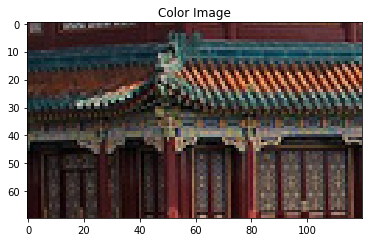

In [18]:
# The original color image
plt.imshow(image)
plt.title('Color Image')
plt.show()

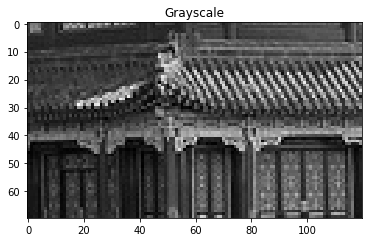

In [19]:
# See what the image looks like in grayscale
plt.imshow(images[0, :, :, 0], cmap="gray")
plt.title('Grayscale')
plt.show()

# Filters

Next we construct two filters, that are sensitive to horizontal and vertical features in the image.

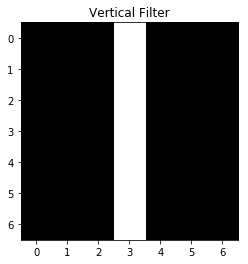

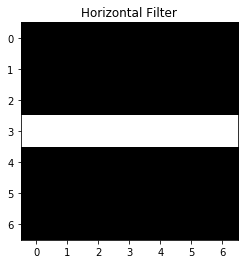

In [20]:
# Create 2 filters
# The shape of the  filter is [height, width, channels, filters]

fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1 # first filter
fmap[3, :, 0, 1] = 1 # second filter

plt.imshow(fmap[:, :, 0, 0], cmap="gray", interpolation="nearest")
plt.title('Vertical Filter')
plt.show()

plt.imshow(fmap[:, :, 0, 1], cmap="gray", interpolation="nearest")
plt.title('Horizontal Filter')
plt.show()

Above we can see that we have two 7 by 7 filters. One is a vertical filter, and the other horizontal. 

Now we apply the two filters to the grayscale image and then look at the resulting two new images. The first which is passed through a horizontal filter and the second a vertical filter. Note how we make use of "SAME" padding to retain the image dimensions.  

In [21]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1, 1, 1, 1], padding="SAME")

with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

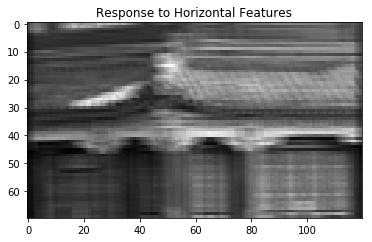

In [22]:
plt.imshow(output[0, :, :, 1], cmap="gray")
plt.title('Response to Horizontal Features')
plt.show()

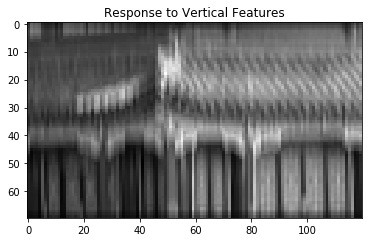

In [23]:
plt.imshow(output[0, :, :, 0], cmap="gray")
plt.title('Response to Vertical Features')
plt.show()

Now you can see the affect that the different filters have. For example the vertical filter has left us only with an image composed of vertical lines. Next lets move on to an example using the all familiar MNIST data. 

---
# MNIST Classification Using a Convolutional Neural Networks

The construction uses **tf.layers.conv2**. A few things to note:

1. The default initialization is rather efficient, but details not documented. It is possible to choose your own initilization.

2. The bias is added by default. The documentation is misleading. 

3. The trainable variables are not explicitly named in **tf.layers**. In order to fetch their values, one has to extract them from the default graph. Note the example provided.

4. Dropout is only used during training, and not during testing. The easiest way to do this is to define **keep_prob** as a placeholder. During testing **keep_prob** is set to 1.




### Import the data

The MNIST data is available in TensorFlow and provides a useful helper function for feeding it in mini-batches

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

print()
print(type(mnist.train.images))
print(mnist.train.images.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

<class 'numpy.ndarray'>
(55000, 784)


## Construction Phase
As usual, we start with the construction phase. THe MNIST images are 28 x 28 and are grayscale so only have 1 channel.

We will have 32 different filters, each of size 3 x 3, with a stride of 1. We also add "SAME" padding to ensure that the resulting image is of the same size. Next a max pooling layer is added and then a standard fully connected layer (feed forward NN) with 64 nodes that feed into a softmax with 10 outputs. Dropout is also added in the fully connected layer. 

In [25]:
tf.reset_default_graph()

# The MNIST images
height = 28
width = 28
channels = 1
n_inputs = height*width           

# First convolutional layer
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

# Max Pooling layer
pool2_fmaps = conv1_fmaps

#Fully connected, and output layer
n_fc1 = 64
n_outputs = 10


with tf.name_scope("Inputs"):    
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    X_reshaped = tf.reshape(X, shape=[-1, width, height, channels])
    y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y") 
    keep_prob = tf.placeholder(tf.float32, name="keep_proba")

with tf.name_scope("Conv1"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(pool2, shape=[-1, pool2_fmaps * 14 * 14])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool2_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    
with tf.name_scope("dropout"):
    fc11 = tf.nn.dropout(fc1, keep_prob=keep_prob )
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_prob = tf.nn.softmax(logits, name="Y_prob")

with tf.name_scope("train"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name="xentropy")
    loss = tf.reduce_mean(xentropy, name='loss')
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver()   

## Execution Phase

### Start Training
Now we run the execution phase to train the model on the data. Please note that this can take long (about 10 minutes on my pc), so please be patient.

The model is trained for 10 epochs, with a batch size of 50. Additionally the dropout rate is set to 50% (a standard value).

In [26]:
n_epochs = 10
batch_size = 50

with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
        acc_train = accuracy.eval(feed_dict={X: mnist.train.images, y: mnist.train.labels, keep_prob: 1.0})
        acc_test  = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
        print(epoch, "Train accuracy:", acc_train, ",  Test accuracy:", acc_test)   
    
    var = [v.name for v in tf.trainable_variables()]
    print(var)
    
    # Fetch the variables from the graph
    graph = tf.get_default_graph()
    filters = graph.get_tensor_by_name("conv1/kernel:0").eval()
    bias    = graph.get_tensor_by_name("conv1/bias:0").eval()
    
    # Save the graph and the current values of the variables.
    save_path = saver.save(sess,"./mnist_cnn/mnist.ckpt")   

0 Train accuracy: 0.9811636 ,  Test accuracy: 0.9779
1 Train accuracy: 0.9874 ,  Test accuracy: 0.9831
2 Train accuracy: 0.99 ,  Test accuracy: 0.9831
3 Train accuracy: 0.9922909 ,  Test accuracy: 0.9836
4 Train accuracy: 0.9964727 ,  Test accuracy: 0.987
5 Train accuracy: 0.9964727 ,  Test accuracy: 0.9841
6 Train accuracy: 0.9971091 ,  Test accuracy: 0.9845
7 Train accuracy: 0.9960727 ,  Test accuracy: 0.9841
8 Train accuracy: 0.9976364 ,  Test accuracy: 0.9854
9 Train accuracy: 0.9962364 ,  Test accuracy: 0.9838
['conv1/kernel:0', 'conv1/bias:0', 'fc1/kernel:0', 'fc1/bias:0', 'output/kernel:0', 'output/bias:0']


Great the model has been trained and you should have a test accuracy above 98%!

If we want to have a look at the variables from the graph, we can do so below. 

In [27]:
print('filters:', filters.shape, 'bias:', bias.shape)
print('bias:',bias)

filters: (3, 3, 1, 32) bias: (32,)
bias: [-0.21391982 -0.00094368 -0.22411765 -0.01227435 -0.08120982 -0.2032379
 -0.18339497 -0.01951492 -0.14985445 -0.20981443 -0.20136009 -0.14826804
 -0.06141082 -0.16475852 -0.05373911 -0.09444895 -0.1002607  -0.13797547
 -0.12806681 -0.02573098 -0.20530017 -0.00573664 -0.27695793 -0.22163717
 -0.01238952 -0.14137559 -0.07772201 -0.05206067 -0.06555817 -0.17443494
 -0.04171394 -0.00393423]
